In [1]:
import tensorflow as tf
from tensorflow.python.layers.base import Layer
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import time
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("mnist/", one_hot=True)

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [8]:
num_train=mnist.train.num_examples
num_val=mnist.validation.num_examples
num_test=mnist.test.num_examples

In [3]:
tf.reset_default_graph()
class CNN_block(Layer):
    def __init__(self,out_kernel_size):
        self.cnn1=tf.layers.Conv2D(out_kernel_size,kernel_size=3,strides=(1, 1),padding='same',name='conv1')
        self.cnn2=tf.layers.Conv2D(out_kernel_size,kernel_size=3,strides=(1, 1),padding='same',name='conv2')
        self.cnn3=tf.layers.Conv2D(out_kernel_size,kernel_size=3,strides=(1, 1),padding='same',name='conv3')
        self.batch_norm1=tf.layers.BatchNormalization(axis=3,name='bn1')
        self.batch_norm2=tf.layers.BatchNormalization(axis=3,name='bn2')
        self.batch_norm3=tf.layers.BatchNormalization(axis=3,name='bn3')
        self.maxpool=tf.layers.MaxPooling2D([2,2],[2,2])
    
    def __call__(self,inputs,is_training):
        out1=tf.nn.relu(self.batch_norm1(inputs=self.cnn1(inputs),training=is_training))
        out2=tf.nn.relu(self.batch_norm2(inputs=self.cnn2(out1),training=is_training))
        out3=tf.nn.relu(self.batch_norm3(inputs=self.cnn3(out2),training=is_training))
        return self.maxpool(out3)

X=tf.placeholder(dtype=tf.float32,shape=[None,28,28,1],name='X')
y=tf.placeholder(dtype=tf.int64,shape=[None,10],name='y')
is_training=tf.placeholder(dtype=tf.bool,name='is_training')

cnn_block1=CNN_block(64)
cnn_block2=CNN_block(128)
out1=cnn_block1(X,is_training)
out2=cnn_block2(out1,is_training)

flt=tf.layers.flatten(out2)
out1=tf.nn.relu(tf.layers.dense(flt,512))
out2=tf.nn.relu(tf.layers.dense(out1,512))
score=tf.layers.dense(out2,10)
predictions = tf.argmax(score, 1)
correct_predictions = tf.equal(predictions, tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"))

loss=tf.losses.softmax_cross_entropy(onehot_labels=y,logits=score)
optimizier=tf.train.AdamOptimizer(learning_rate=1e-5)
train_step = optimizier.minimize(loss)

In [ ]:
max_epoch=10
batch_size=8
print_every=625

def train():
    num_iteration=num_train//batch_size
    for it in range(num_iteration):
        images,labels=mnist.train.next_batch(batch_size)
        extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)  # update runing mean in batch normalization
        loss_num,_,__ = sess.run([loss,train_step,extra_update_ops],feed_dict={X:images.reshape(-1,28,28,1),y:labels,is_training:True})
        if it==0 or (it+1)%print_every==0 or it==num_iteration-1:
            print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),
                  'iteration %d/%d:' % (it+1,num_iteration),'current training loss = %f' % (loss_num))
            
def eval(dataset,num_iteration):
    total_loss=0
    total_accuracy=0
    for it in range(num_iteration):
        images,labels=dataset.next_batch(batch_size)
        loss_num,accuracy_num = sess.run([loss,accuracy],feed_dict={X:images.reshape(-1,28,28,1),
                                                                    y:labels,is_training:False})
        total_loss+=loss_num
        total_accuracy+=accuracy_num
    total_loss/=num_iteration
    total_accuracy/=num_iteration
    return total_loss,total_accuracy

In [4]:
acc_train_his=[]
acc_val_his=[]
acc_test_his=[]

saver=tf.train.Saver()
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    max_acc=None
    for epoch in range(max_epoch):
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),'start epoch %d/%d:' % (epoch+1,max_epoch))
        train()
        loss_train,acc_train=eval(mnist.train,2000)
        loss_val,acc_val=eval(mnist.validation,500)
        loss_test,acc_test=eval(mnist.test,1000)
        acc_train_his.append(acc_train)
        acc_val_his.append(acc_val)
        acc_test_his.append(acc_test)
        
        if max_acc==None or acc_val>max_acc:
            max_acc=acc_val
            save_path = saver.save(sess, "model/CNN/CNN.ckpt")
            print("Currently maximum accuracy on validation set, model saved in path: %s" % save_path)
            
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),'end epoch %d/%d:' % (epoch+1,max_epoch),
             'acc_train=%.3f%% acc_val=%.3f%% acc_test=%.3f%%' % (acc_train*100.0,acc_val*100.0,acc_test*100.0))

2018-04-17 12:30:29 start epoch 1/10:
2018-04-17 12:30:31 iteration 1/6875: current training loss = 3.117106
2018-04-17 12:30:36 iteration 625/6875: current training loss = 0.979125
2018-04-17 12:30:41 iteration 1250/6875: current training loss = 0.220241
2018-04-17 12:30:46 iteration 1875/6875: current training loss = 0.007038
2018-04-17 12:30:52 iteration 2500/6875: current training loss = 0.016273
2018-04-17 12:30:57 iteration 3125/6875: current training loss = 0.120919
2018-04-17 12:31:02 iteration 3750/6875: current training loss = 0.120668
2018-04-17 12:31:08 iteration 4375/6875: current training loss = 0.027001
2018-04-17 12:31:13 iteration 5000/6875: current training loss = 0.008089
2018-04-17 12:31:19 iteration 5625/6875: current training loss = 0.084987
2018-04-17 12:31:24 iteration 6250/6875: current training loss = 0.003175
2018-04-17 12:31:29 iteration 6875/6875: current training loss = 0.002731
Currently maximum accuracy on validation set, model saved in path: model/CNN/C

2018-04-17 12:39:24 iteration 5625/6875: current training loss = 0.000005
2018-04-17 12:39:29 iteration 6250/6875: current training loss = 0.000011
2018-04-17 12:39:35 iteration 6875/6875: current training loss = 0.025562
2018-04-17 12:39:44 end epoch 8/10: acc_train=99.913% acc_val=98.825% acc_test=99.250%
2018-04-17 12:39:44 start epoch 9/10:
2018-04-17 12:39:44 iteration 1/6875: current training loss = 0.000023
2018-04-17 12:39:49 iteration 625/6875: current training loss = 0.000003
2018-04-17 12:39:54 iteration 1250/6875: current training loss = 0.000848
2018-04-17 12:40:00 iteration 1875/6875: current training loss = 0.002909
2018-04-17 12:40:05 iteration 2500/6875: current training loss = 0.000094
2018-04-17 12:40:10 iteration 3125/6875: current training loss = 0.000401
2018-04-17 12:40:16 iteration 3750/6875: current training loss = 0.000028
2018-04-17 12:40:21 iteration 4375/6875: current training loss = 0.000006
2018-04-17 12:40:27 iteration 5000/6875: current training loss = 

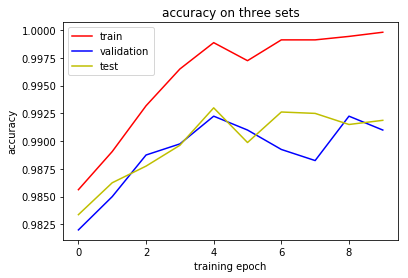

In [5]:
plt.figure(1)
ptr,=plt.plot(range(max_epoch),acc_train_his,'r-')
pva,=plt.plot(range(max_epoch),acc_val_his,'b-')
pte,=plt.plot(range(max_epoch),acc_test_his,'y-')
plt.xlabel('training epoch')
plt.ylabel('accuracy')
plt.title('accuracy on three sets')
plt.legend((ptr,pva,pte),('train','validation','test'))
plt.show()

In [9]:
saver=tf.train.Saver()
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    saver.restore(sess, "model/CNN/CNN.ckpt")
    _,acc_train=eval(mnist.train,num_train//batch_size)
    _,acc_val=eval(mnist.validation,num_val//batch_size)
    _,acc_test=eval(mnist.test,num_test//batch_size)
    print('Accuracy on training set is %.3f%%' % (acc_train*100.0))
    print('Accuracy on validation set is %.3f%%' % (acc_val*100.0))
    print('Accuracy on testing set is %.3f%%' % (acc_test*100.0))

INFO:tensorflow:Restoring parameters from model/CNN/CNN.ckpt
Accuracy on training set is 99.911%
Accuracy on validation set is 99.220%
Accuracy on testing set is 99.250%
